In [57]:
# library dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [58]:
# raw data file and path
datafile = '../data/preproc_stage2.csv'

# sanity check if the file exists
if not Path(datafile).is_file():
    print('Data file not found!')

In [59]:
# reading the data into a dataframe and looking at the first entries
df = pd.read_csv(datafile)
df

,EnsemblTranscriptID,Adrenal_PTR,Appendices_PTR,Brain_PTR,Colon_PTR,Duodenum_PTR,Endometrium_PTR,Esophagus_PTR,Fallopiantube_PTR,Fat_PTR,...,Thyroid_PTR,Tonsil_PTR,Urinarybladder_PTR,5UTR start,5UTR stop,CDS start,CDS stop,3UTR start,3UTR stop,transcript
0,ENST00000263100,NaN,8.277,NaN,NaN,NaN,NaN,NaN,7.841,NaN,...,NaN,NaN,NaN,0,55,55,1543,1543,3382,ATTGCTGCAGACGCTCACCCCAGACACTCACTGCACCGGAGTGAGC...
1,ENST00000373993,NaN,NaN,NaN,5.135,5.371,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,92,92,1877,1877,2044,ATAATCAAGGAAACCTTTTCCGGGTGGGGATCTCTGAAATTACTCA...
2,ENST00000318602,6.290,6.328,5.948,5.811,6.068,5.383,5.881,6.119,6.410,...,6.060,5.675,5.8286,0,70,70,4495,4495,4610,GGGACCAGATGGATTGTAGGGAGTAGGGTACAATACAGTCTGTTCT...
3,ENST00000299698,NaN,NaN,3.995,NaN,NaN,NaN,4.129,NaN,NaN,...,NaN,5.249,NaN,0,31,31,4396,4396,5127,GACCCTGGAAAAATCTGTCTCACCCACAAAGATGTGGGCTCAGCTC...
4,ENST00000401850,3.843,4.601,NaN,NaN,NaN,NaN,4.013,3.683,NaN,...,NaN,NaN,4.2430,0,490,490,1552,1552,2321,TGCACTTCTGTGCCTCAATTTCCTCATCTGTAGGGTGGGGGTGGTG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11558,ENST00000374888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.681,NaN,0,38,38,2450,2450,5467,CTCGGCTCTGGTTCCAGCCGAGCCTCTCGGACGCAGAGATGGAAAT...
11559,ENST00000294353,4.461,5.013,5.047,4.566,5.184,4.826,5.102,4.670,5.756,...,4.250,4.439,4.1460,0,201,201,2436,2436,8143,GGAGTCTGCGCTCTGGTTCGGGCTGCGGCTGCGGCTGCGGCTGCGG...
11560,ENST00000322764,5.664,5.524,5.478,5.915,5.811,5.817,5.943,5.509,4.931,...,5.598,5.968,5.3358,0,80,80,1799,1799,2228,GCAGAGTCTGCGGACCCGGCGCCGAGGCGGCCACCCGAGACGCGGC...
11561,ENST00000381638,5.112,4.918,5.139,5.190,5.442,5.602,4.715,4.956,5.033,...,5.038,5.130,5.0619,0,135,135,9021,9021,11466,AGGAAGCCGGAAGCCGCAGGGGCCGCCGTCGTCTCCTCCGCGTCCC...


In [67]:
def build_kmers(seq, ksize):
    temp_seq = seq.strip()
    kmer_count = len(temp_seq) - ksize + 1
    kmers = []
    
    for i in range(0, kmer_count):
        kmer = temp_seq[i:i+ksize]
        kmers.append(kmer)

    return kmers

In [69]:
# update dataframe with kmers

kmer_size = 3

for index, row in df.iterrows():
    kmers = build_kmers(row['transcript'], kmer_size)
    df.loc[ df['EnsemblTranscriptID'] == row['EnsemblTranscriptID'], 'kmers'] = ' '.join(kmers)

In [78]:
df['transcript'].head(1).to_string(index=False)

'ATTGCTGCAGACGCTCACCCCAGACACTCACTGCACCGGAGTGAGCG...'

In [77]:
df['kmers'].head(1).to_string(index=False)

'ATT TTG TGC GCT CTG TGC GCA CAG AGA GAC ACG CGC...'

In [99]:
# build the embedding vocabulary
import itertools
trip_voc = [''.join(x) for x in itertools.product('ATGC', repeat=3)]
len(trip_voc)

64

In [93]:
from keras.layers import Hashing
layer = Hashing(num_bins=64, output_mode='one_hot')
layer(trip_voc)

<tf.Tensor: shape=(64, 64), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [115]:
import tensorflow as tf

raw_sequence = 'ATT TTG TGC GCT CTG TGC GCA CAG AGA GAC ACG CGC'

tvlayer = tf.keras.layers.TextVectorization(max_tokens=66, standardize=None, split='whitespace', output_mode='int', vocabulary=trip_voc)

# layer.get_vocabulary()

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(tvlayer)
model.predict([raw_sequence])

1/1 [==============================] - 0s 36ms/step


array([[ 7, 24, 29, 47, 56, 29, 46, 52, 10, 37, 16, 61]])

In [52]:
# just for fun check how often each of the possible kmer permutations
# show up in all the sequences and plot that

kmer_size = 3
global_voc = {}

def build_kmers_voc(seq, ksize):
    temp_seq = seq.strip()
    voc = {}
    kmer_count = len(temp_seq) - ksize + 1
    
    for i in range(0, kmer_count):
        kmer = temp_seq[i:i+ksize]
        if kmer in voc.keys():
            voc[kmer] += 1
        else:
            voc[kmer] = 1

    return voc

for index, row in df.iterrows():
    temp_voc = build_kmers_voc(row['transcript'], kmer_size)

    for k in temp_voc.keys():
        if k in global_voc.keys():
            global_voc[k] += temp_voc[k]
        else:
            global_voc[k] = temp_voc[k]

global_voc

{'ATT': 739650,
 'TTG': 724389,
 'TGC': 754418,
 'GCT': 756853,
 'CTG': 1100563,
 'GCA': 732445,
 'CAG': 1080107,
 'AGA': 975064,
 'GAC': 548173,
 'ACG': 218678,
 'CGC': 308592,
 'CTC': 742140,
 'TCA': 747841,
 'CAC': 649311,
 'ACC': 614791,
 'CCC': 832754,
 'CCA': 912247,
 'ACA': 746467,
 'ACT': 617351,
 'CCG': 361658,
 'CGG': 360866,
 'GGA': 882671,
 'GAG': 880698,
 'AGT': 631740,
 'GTG': 744676,
 'TGA': 836525,
 'AGC': 798473,
 'GCG': 315760,
 'CGA': 228163,
 'CAT': 670070,
 'ATC': 526845,
 'ATG': 756185,
 'TGT': 787006,
 'GTC': 453446,
 'TCC': 729437,
 'TCG': 200936,
 'CGT': 199617,
 'TGG': 947444,
 'GGT': 505064,
 'TCT': 779587,
 'CTT': 767026,
 'TTT': 1142334,
 'TTC': 735772,
 'GGG': 730820,
 'CCT': 885115,
 'GGC': 756951,
 'GCC': 814638,
 'GAA': 916207,
 'AAG': 911201,
 'ATA': 524878,
 'TAT': 567234,
 'TTA': 591520,
 'AAT': 732574,
 'AAA': 1180438,
 'AAC': 575114,
 'CAA': 738078,
 'AGG': 835558,
 'GTT': 545369,
 'CTA': 429732,
 'TAC': 423691,
 'GAT': 577099,
 'GTA': 380767,
 'TA

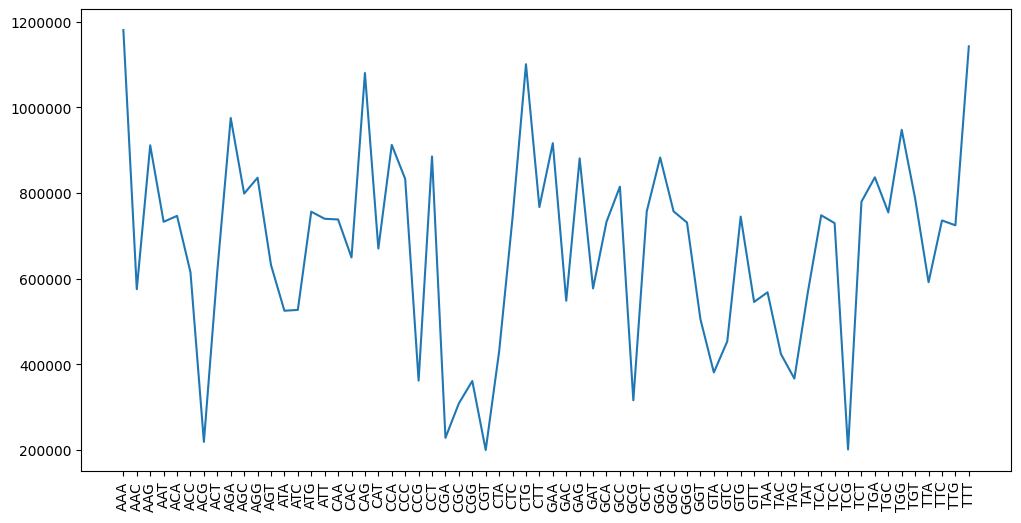

In [53]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
plt.ticklabel_format(axis='y', style='plain')
plt.plot(*zip(*sorted(global_voc.items())))
# plt.plot(global_voc.keys(), global_voc.values())
plt.show()